# EDA: Google Cluster Trace 2019 - Demand-Only Analysis (CORRECTED)

This notebook performs **corrected** exploratory data analysis on workload demand from Google Cloud Traces 2019.

## Critical Corrections Applied

1. **NO REAL TIMESTAMPS**: Google Trace 2019 does NOT contain real timestamps. All temporal analysis uses `bucket_index` (derived from `bucket_s`).
2. **Synthetic Time Features**: Hour-of-day, day-of-week features are synthetic and used ONLY for seasonality pattern detection.
3. **Machine Counts**: The `machines` column represents machines reporting usage, NOT total cluster capacity.
4. **Instance Events Mismatch**: `new_instances_cluster` includes tasks that may not appear in usage data - requires normalization.
5. **Memory Units**: Memory values are already normalized (likely in GB based on magnitude).

## Data Available

- `data/processed/machine_level.parquet`: Per-machine CPU/memory demand
- `data/processed/cluster_level.parquet`: Aggregated cluster-wide demand

**Columns:**
- `bucket_s`: Seconds since trace start (300s = 5min intervals)
- `cpu_demand` / `cpu_used`: CPU usage in cores
- `mem_demand` / `mem_used`: Memory usage (normalized, likely GB)
- `machines`: Number of machines reporting usage in this bucket
- `new_instances_cluster` / `new_instances_machine`: New instance arrivals

## Analysis Structure

1. Setup & Data Loading
2. Data Quality & Coverage Analysis
3. Temporal Analysis with bucket_index
4. Demand Distribution & Statistics
5. New Instance Analysis (with normalization)
6. Temporal Patterns & Rolling Statistics
7. Spike Detection
8. ACF/PACF Analysis for Forecastability
9. Correlation Analysis
10. ML-Ready Feature Engineering
11. Autoscaler-Ready Summary


## 0. Setup & Imports


In [1]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import warnings

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Create output directory for summary tables
output_dir = Path("eda_summary")
output_dir.mkdir(exist_ok=True)

print("✅ Imports complete")
print(f"📁 Output directory: {output_dir.absolute()}")


✅ Imports complete
📁 Output directory: /Users/medhatabouzeid/Documents/00-Projects/_AUS/Cloud-AutoScale/scripts/eda_summary


## 1. Data Loading & Schema Verification


In [2]:
# Load datasets using Polars
print("📂 Loading datasets...")

ml = pl.read_parquet("../data/processed/machine_level.parquet")
cl = pl.read_parquet("../data/processed/cluster_level.parquet")

print(f"✅ Machine-level data: {len(ml):,} rows")
print(f"✅ Cluster-level data: {len(cl):,} rows")
print("\n" + "="*80)
print("CLUSTER-LEVEL SCHEMA")
print("="*80)
print(cl.schema)
print("\n" + "="*80)
print("MACHINE-LEVEL SCHEMA")
print("="*80)
print(ml.schema)


📂 Loading datasets...
✅ Machine-level data: 29,738,704 rows
✅ Cluster-level data: 8,929 rows

CLUSTER-LEVEL SCHEMA
Schema({'bucket_s': Float64, 'cpu_demand': Float64, 'mem_demand': Float64, 'machines': UInt32, 'bucket_index': Int64, 'new_instances_cluster': UInt32})

MACHINE-LEVEL SCHEMA
Schema({'bucket_s': Float64, 'machine_id': Int64, 'cpu_used': Float64, 'mem_used': Float64, 'num_records': UInt32, 'bucket_index': Int64, 'new_instances_machine': UInt32})


In [3]:
# Display sample data
print("Cluster-Level Sample (first 10 rows):")
display(cl.head(10))

print("\nMachine-Level Sample (first 10 rows):")
display(ml.head(10))


Cluster-Level Sample (first 10 rows):


bucket_s,cpu_demand,mem_demand,machines,bucket_index,new_instances_cluster
f64,f64,f64,u32,i64,u32
300.0,10.283436,4.215649,2195,0,0
600.0,11.116977,4.543966,2209,1,14451
900.0,10.353116,4.374648,2218,2,15688
1200.0,12.320097,4.651689,2221,3,13254
1500.0,12.255638,4.91491,2223,4,12053
1800.0,11.707062,4.87446,2237,5,15087
2100.0,12.690164,4.696465,2220,6,21694
2400.0,12.034664,5.0016,2435,7,16190
2700.0,14.082071,5.576172,2423,8,20211



Machine-Level Sample (first 10 rows):


bucket_s,machine_id,cpu_used,mem_used,num_records,bucket_index,new_instances_machine
f64,i64,f64,f64,u32,i64,u32
300.0,20733625,0.007027,0.002541,1,0,0
300.0,20736591,0.000536,0.000986,1,0,0
300.0,20736663,0.005363,0.002132,1,0,0
300.0,20736671,0.004985,0.001817,2,0,0
300.0,20736678,0.000405,0.00013,1,0,0
300.0,20736684,0.000383,0.000175,1,0,0
300.0,20736694,0.006317,0.001169,1,0,0
300.0,20736698,0.001268,0.002098,1,0,0
300.0,20736882,0.006523,0.001257,1,0,0


## 2. Data Quality & Coverage Analysis

**Critical:** Assess data completeness, missing buckets, and machine coverage.


In [4]:
# Create bucket_index for temporal analysis
# bucket_s starts at 300, so bucket_index = (bucket_s / 300) - 1
cl = cl.with_columns([
    ((pl.col('bucket_s') / 300) - 1).cast(pl.Int64).alias('bucket_index')
])

ml = ml.with_columns([
    ((pl.col('bucket_s') / 300) - 1).cast(pl.Int64).alias('bucket_index')
])

print("✅ Created bucket_index for temporal analysis")
print(f"   Bucket index range: {cl['bucket_index'].min()} to {cl['bucket_index'].max()}")
print(f"   Expected buckets: {cl['bucket_index'].max() - cl['bucket_index'].min() + 1}")
print(f"   Actual buckets: {len(cl)}")


✅ Created bucket_index for temporal analysis
   Bucket index range: 0 to 8928
   Expected buckets: 8929
   Actual buckets: 8929


In [5]:
# Check for missing buckets
min_idx = cl['bucket_index'].min()
max_idx = cl['bucket_index'].max()
expected_buckets = set(range(min_idx, max_idx + 1))
actual_buckets = set(cl['bucket_index'].to_list())
missing_buckets = expected_buckets - actual_buckets

print("="*80)
print("DATA COVERAGE ANALYSIS")
print("="*80)
print(f"Expected bucket count: {len(expected_buckets):,}")
print(f"Actual bucket count:   {len(actual_buckets):,}")
print(f"Missing buckets:       {len(missing_buckets):,}")

if len(missing_buckets) > 0:
    print(f"\n⚠️  WARNING: {len(missing_buckets)} buckets are missing!")
    print(f"   Missing bucket indices (first 20): {sorted(list(missing_buckets))[:20]}")
else:
    print("\n✅ No missing buckets - complete temporal coverage")


DATA COVERAGE ANALYSIS
Expected bucket count: 8,929
Actual bucket count:   8,929
Missing buckets:       0

✅ No missing buckets - complete temporal coverage


In [6]:
# Machine coverage analysis
total_unique_machines = ml['machine_id'].n_unique()
machines_per_bucket = ml.group_by('bucket_index').agg([
    pl.col('machine_id').n_unique().alias('unique_machines'),
    pl.count().alias('records')
]).sort('bucket_index')

print("\n" + "="*80)
print("MACHINE COVERAGE ANALYSIS")
print("="*80)
print(f"Total unique machines across all buckets: {total_unique_machines:,}")
print(f"\nMachines per bucket statistics:")
print(machines_per_bucket['unique_machines'].describe())

# Check for buckets with very low machine counts
low_coverage = machines_per_bucket.filter(pl.col('unique_machines') < 100)
if len(low_coverage) > 0:
    print(f"\n⚠️  WARNING: {len(low_coverage)} buckets have < 100 machines reporting")
    print("   This may indicate data quality issues.")
else:
    print("\n✅ All buckets have adequate machine coverage")



MACHINE COVERAGE ANALYSIS
Total unique machines across all buckets: 9,995

Machines per bucket statistics:
shape: (9, 2)
┌────────────┬────────────┐
│ statistic  ┆ value      │
│ ---        ┆ ---        │
│ str        ┆ f64        │
╞════════════╪════════════╡
│ count      ┆ 8929.0     │
│ null_count ┆ 0.0        │
│ mean       ┆ 3330.57498 │
│ std        ┆ 744.941014 │
│ min        ┆ 1587.0     │
│ 25%        ┆ 2915.0     │
│ 50%        ┆ 3409.0     │
│ 75%        ┆ 3728.0     │
│ max        ┆ 7499.0     │
└────────────┴────────────┘

✅ All buckets have adequate machine coverage


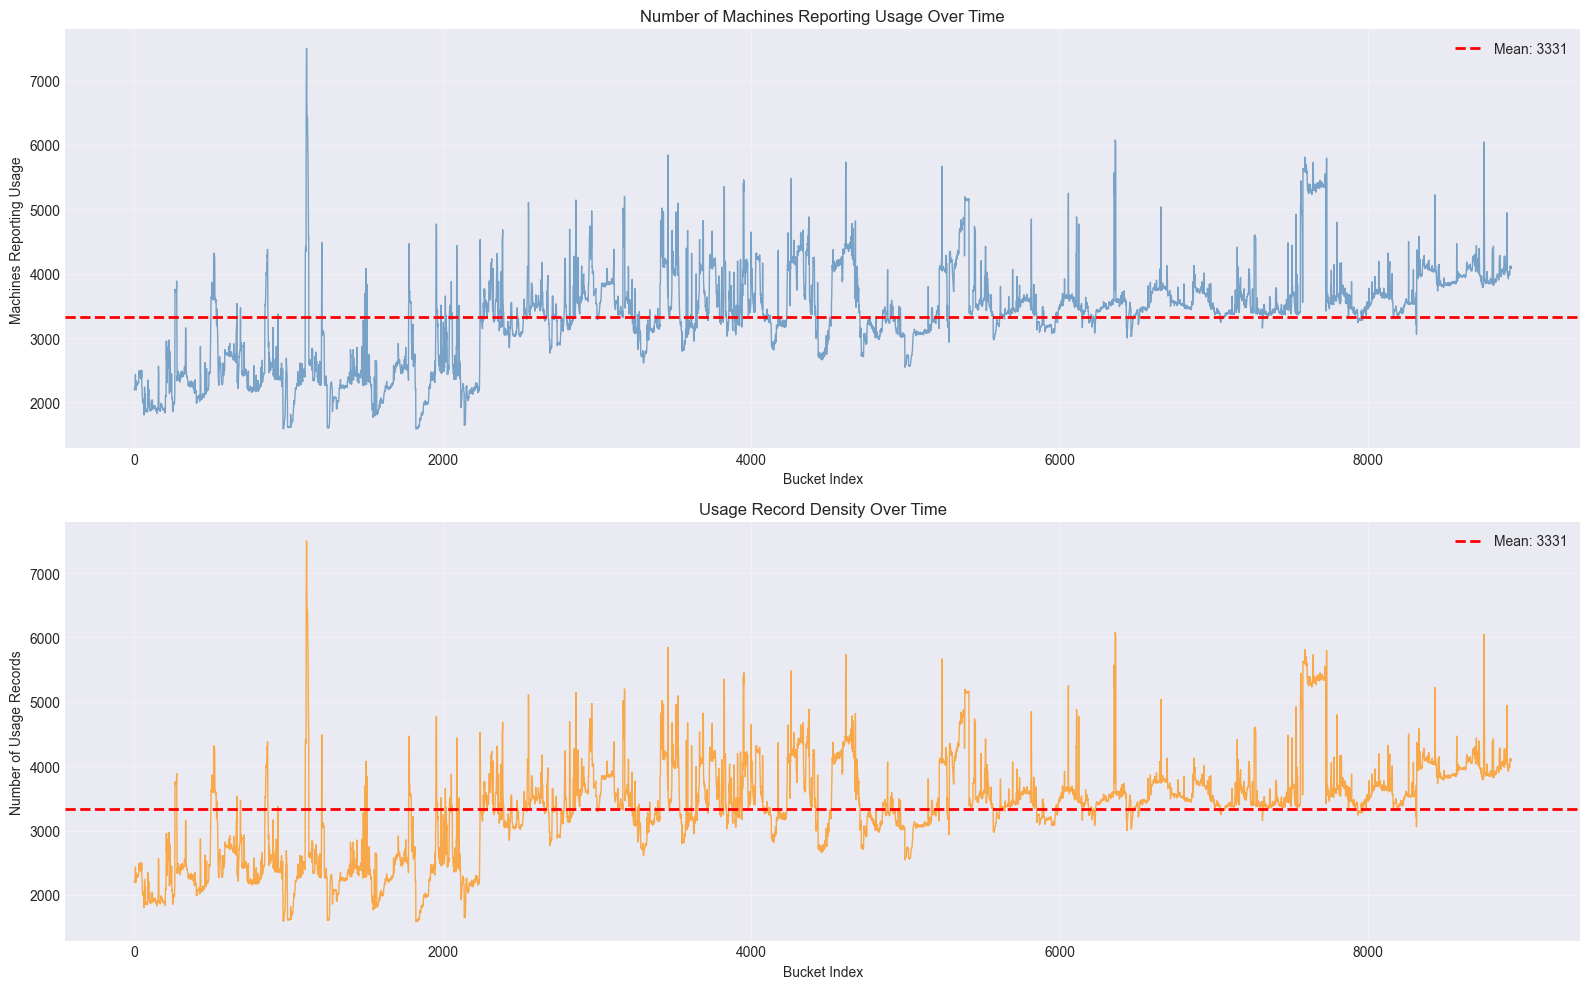


📊 Interpretation:
   - 'machines' column represents machines reporting usage, NOT total capacity
   - Variations indicate dynamic cluster behavior
   - Sparse coverage may indicate partial data or machine churn


In [7]:
# Plot machine coverage over time
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Machines reporting per bucket
cl_sorted = cl.sort('bucket_index')
axes[0].plot(cl_sorted['bucket_index'], cl_sorted['machines'], linewidth=1, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Bucket Index')
axes[0].set_ylabel('Machines Reporting Usage')
axes[0].set_title('Number of Machines Reporting Usage Over Time')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(cl_sorted['machines'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {cl_sorted["machines"].mean():.0f}')
axes[0].legend()

# Records per bucket (usage density)
axes[1].plot(machines_per_bucket['bucket_index'], machines_per_bucket['records'], 
             linewidth=1, alpha=0.7, color='darkorange')
axes[1].set_xlabel('Bucket Index')
axes[1].set_ylabel('Number of Usage Records')
axes[1].set_title('Usage Record Density Over Time')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(machines_per_bucket['records'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {machines_per_bucket["records"].mean():.0f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   - 'machines' column represents machines reporting usage, NOT total capacity")
print("   - Variations indicate dynamic cluster behavior")
print("   - Sparse coverage may indicate partial data or machine churn")


## 3. Temporal Coverage & Basic Statistics

**Using bucket_index for all temporal analysis** (NOT real timestamps)


In [8]:
# Temporal coverage
bucket_interval_s = 300  # 5 minutes
total_duration_s = (cl['bucket_index'].max() + 1) * bucket_interval_s
total_duration_hours = total_duration_s / 3600
total_duration_days = total_duration_hours / 24

print("="*80)
print("TEMPORAL COVERAGE (using bucket_index)")
print("="*80)
print(f"Bucket interval:     {bucket_interval_s} seconds (5 minutes)")
print(f"Total buckets:       {cl['bucket_index'].max() + 1:,}")
print(f"Total duration:      {total_duration_hours:.1f} hours ({total_duration_days:.1f} days)")
print(f"Bucket index range:  {cl['bucket_index'].min()} to {cl['bucket_index'].max()}")

print("\n" + "="*80)
print("DEMAND STATISTICS")
print("="*80)
print(f"CPU Demand:    min={cl['cpu_demand'].min():.2f}, max={cl['cpu_demand'].max():.2f}, "
      f"mean={cl['cpu_demand'].mean():.2f}, std={cl['cpu_demand'].std():.2f}")
print(f"Memory Demand: min={cl['mem_demand'].min():.2f}, max={cl['mem_demand'].max():.2f}, "
      f"mean={cl['mem_demand'].mean():.2f}, std={cl['mem_demand'].std():.2f}")
print(f"\nMachine Count: min={cl['machines'].min():,}, max={cl['machines'].max():,}, "
      f"mean={cl['machines'].mean():.0f}, std={cl['machines'].std():.0f}")
print(f"New Instances: total={cl['new_instances_cluster'].sum():,}, "
      f"mean_per_bucket={cl['new_instances_cluster'].mean():.2f}")


TEMPORAL COVERAGE (using bucket_index)
Bucket interval:     300 seconds (5 minutes)
Total buckets:       8,929
Total duration:      744.1 hours (31.0 days)
Bucket index range:  0 to 8928

DEMAND STATISTICS
CPU Demand:    min=10.22, max=535.82, mean=30.96, std=19.86
Memory Demand: min=3.41, max=142.22, mean=13.59, std=8.07

Machine Count: min=1,587, max=7,499, mean=3331, std=745
New Instances: total=293,583,681, mean_per_bucket=32879.79


## 4. Demand Distribution & Statistics


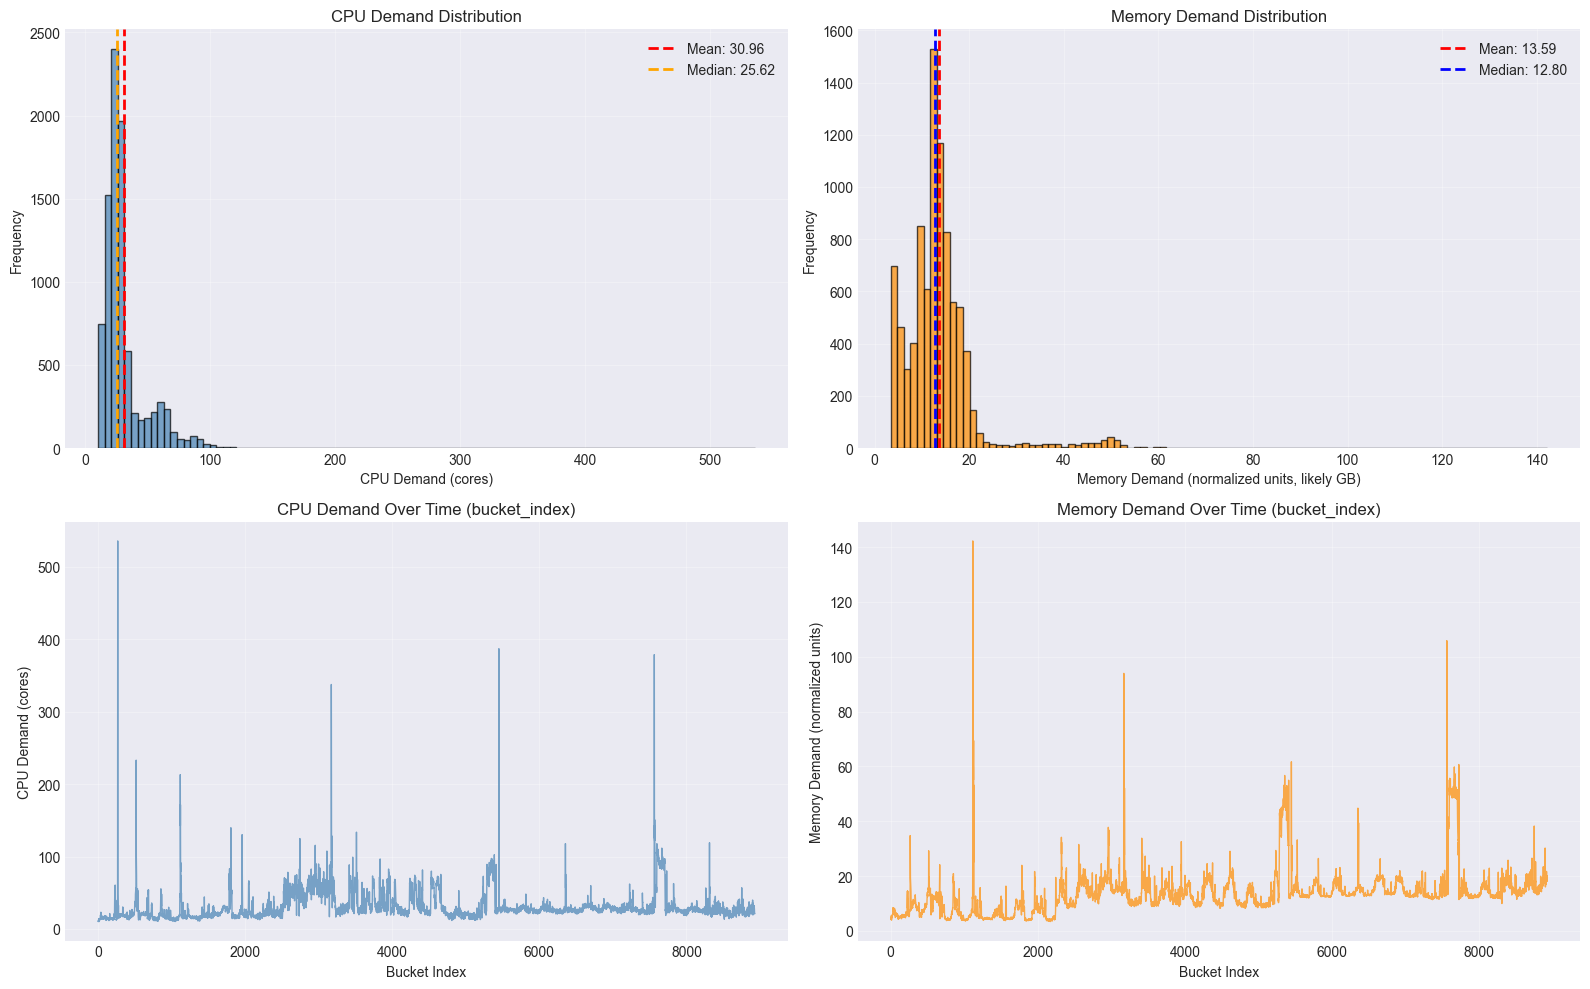

In [9]:
# Convert to pandas for plotting
cl_pd = cl.sort('bucket_index').to_pandas()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CPU demand distribution
axes[0, 0].hist(cl_pd['cpu_demand'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].axvline(cl_pd['cpu_demand'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {cl_pd["cpu_demand"].mean():.2f}')
axes[0, 0].axvline(cl_pd['cpu_demand'].median(), color='orange', linestyle='--', linewidth=2, 
                   label=f'Median: {cl_pd["cpu_demand"].median():.2f}')
axes[0, 0].set_xlabel('CPU Demand (cores)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('CPU Demand Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Memory demand distribution
axes[0, 1].hist(cl_pd['mem_demand'], bins=100, edgecolor='black', alpha=0.7, color='darkorange')
axes[0, 1].axvline(cl_pd['mem_demand'].mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {cl_pd["mem_demand"].mean():.2f}')
axes[0, 1].axvline(cl_pd['mem_demand'].median(), color='blue', linestyle='--', linewidth=2, 
                   label=f'Median: {cl_pd["mem_demand"].median():.2f}')
axes[0, 1].set_xlabel('Memory Demand (normalized units, likely GB)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Memory Demand Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# CPU demand over bucket_index
axes[1, 0].plot(cl_pd['bucket_index'], cl_pd['cpu_demand'], linewidth=1, alpha=0.7, color='steelblue')
axes[1, 0].set_xlabel('Bucket Index')
axes[1, 0].set_ylabel('CPU Demand (cores)')
axes[1, 0].set_title('CPU Demand Over Time (bucket_index)')
axes[1, 0].grid(True, alpha=0.3)

# Memory demand over bucket_index
axes[1, 1].plot(cl_pd['bucket_index'], cl_pd['mem_demand'], linewidth=1, alpha=0.7, color='darkorange')
axes[1, 1].set_xlabel('Bucket Index')
axes[1, 1].set_ylabel('Memory Demand (normalized units)')
axes[1, 1].set_title('Memory Demand Over Time (bucket_index)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
# Percentile analysis
print("="*80)
print("DEMAND PERCENTILES")
print("="*80)
percentiles = [50, 75, 90, 95, 99]
for p in percentiles:
    cpu_p = np.percentile(cl_pd['cpu_demand'], p)
    mem_p = np.percentile(cl_pd['mem_demand'], p)
    print(f"P{p:2d}: CPU={cpu_p:8.2f} cores, Memory={mem_p:8.2f} units")

# Burstiness analysis
cpu_cv = cl_pd['cpu_demand'].std() / cl_pd['cpu_demand'].mean()
mem_cv = cl_pd['mem_demand'].std() / cl_pd['mem_demand'].mean()

print("\n" + "="*80)
print("BURSTINESS ANALYSIS (Coefficient of Variation)")
print("="*80)
print(f"CPU CV:    {cpu_cv:.4f}")
print(f"Memory CV: {mem_cv:.4f}")
print("\nInterpretation:")
print("  CV < 0.5: Low variability (predictable)")
print("  CV 0.5-1.0: Moderate variability")
print("  CV > 1.0: High variability (bursty, challenging for autoscaling)")


DEMAND PERCENTILES
P50: CPU=   25.62 cores, Memory=   12.80 units
P75: CPU=   31.60 cores, Memory=   15.59 units
P90: CPU=   58.25 cores, Memory=   18.93 units
P95: CPU=   67.34 cores, Memory=   21.79 units
P99: CPU=   94.44 cores, Memory=   50.08 units

BURSTINESS ANALYSIS (Coefficient of Variation)
CPU CV:    0.6414
Memory CV: 0.5941

Interpretation:
  CV < 0.5: Low variability (predictable)
  CV 0.5-1.0: Moderate variability
  CV > 1.0: High variability (bursty, challenging for autoscaling)


## 5. New Instance Analysis (with Normalization)

**Critical:** `new_instances_cluster` includes tasks that may NOT appear in usage data. We must normalize this metric.


In [11]:
# Normalize new instances by demand
cl_pd['new_instances_normalized'] = cl_pd['new_instances_cluster'] / (cl_pd['cpu_demand'] + 1e-6)

print("="*80)
print("NEW INSTANCE ANALYSIS")
print("="*80)
print(f"Total new instances:           {cl_pd['new_instances_cluster'].sum():,}")
print(f"Mean new instances per bucket: {cl_pd['new_instances_cluster'].mean():.2f}")
print(f"Max new instances per bucket:  {cl_pd['new_instances_cluster'].max():,}")
print(f"\nNormalized ratio (instances/demand):")
print(f"  Mean:   {cl_pd['new_instances_normalized'].mean():.2f}")
print(f"  Median: {cl_pd['new_instances_normalized'].median():.2f}")
print(f"  Max:    {cl_pd['new_instances_normalized'].max():.2f}")

# Detect extreme divergence
high_ratio = cl_pd[cl_pd['new_instances_normalized'] > 10000]
print(f"\n⚠️  Buckets with extreme instance/demand ratio (>10000): {len(high_ratio)}")
if len(high_ratio) > 0:
    print("   This indicates instance_events include many tasks not reflected in usage data.")
    print("   These must be normalized before use in ML or autoscaling.")


NEW INSTANCE ANALYSIS
Total new instances:           293,583,681
Mean new instances per bucket: 32879.79
Max new instances per bucket:  160,408

Normalized ratio (instances/demand):
  Mean:   1279.90
  Median: 1150.85
  Max:    7864.25

⚠️  Buckets with extreme instance/demand ratio (>10000): 0


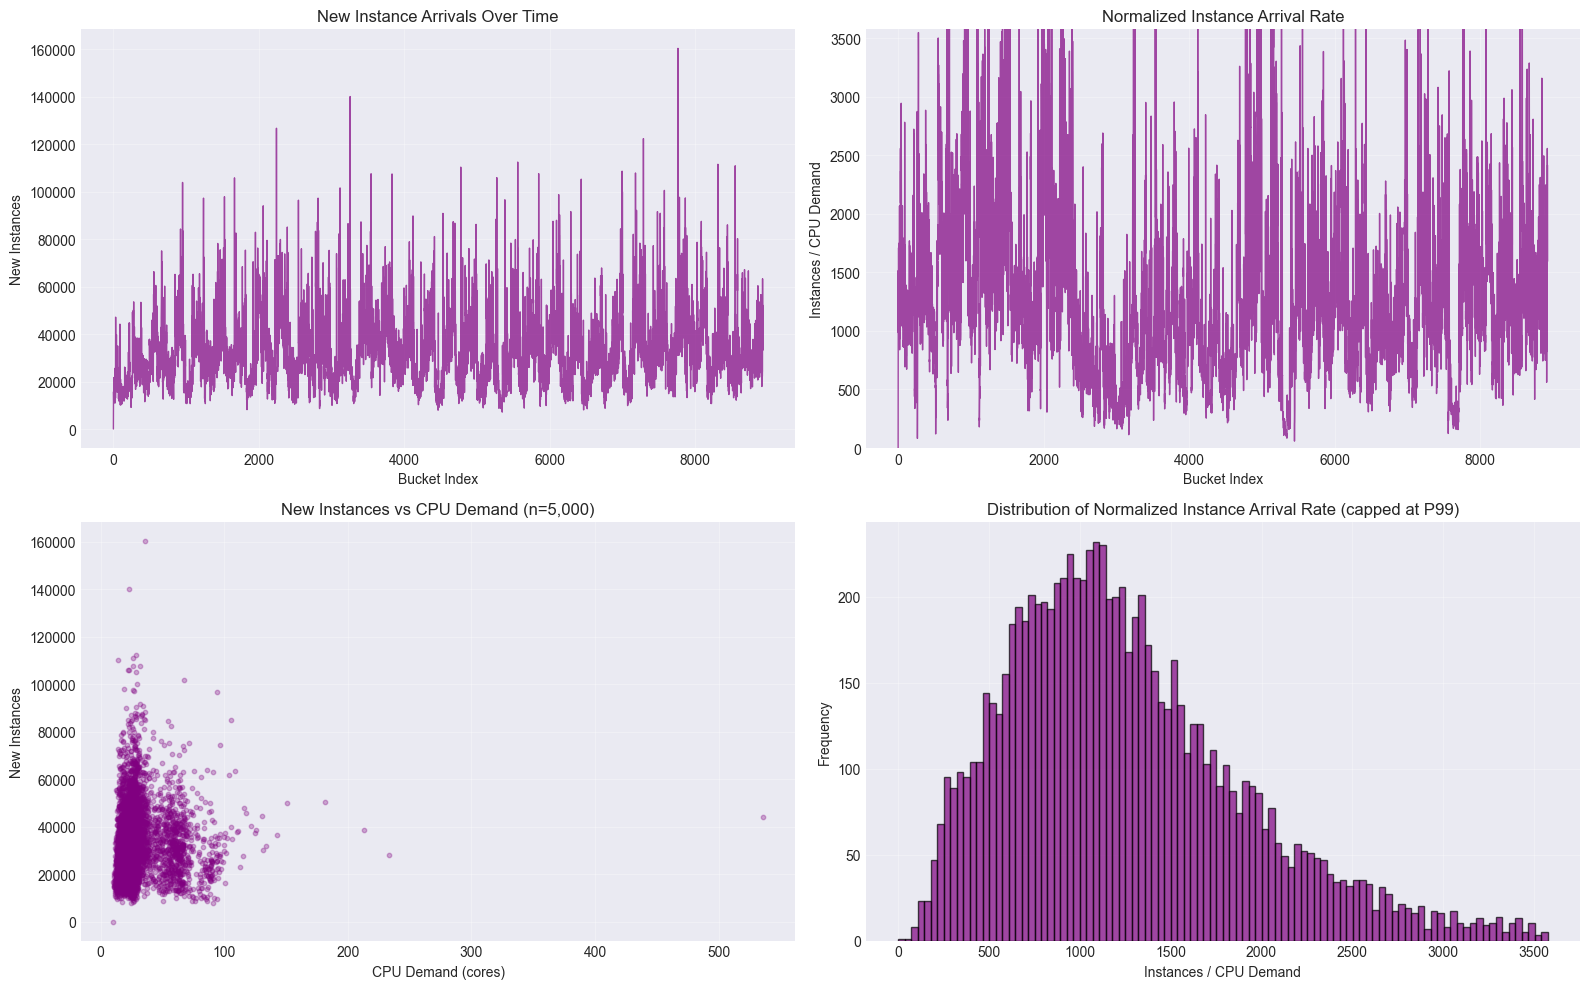


📊 Interpretation:
   - Instance events and usage data are NOT perfectly aligned
   - Many instance arrivals do not contribute to measured usage
   - Normalization is essential before using this feature in ML models


In [12]:
# Plot new instances vs demand
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# New instances over time
axes[0, 0].plot(cl_pd['bucket_index'], cl_pd['new_instances_cluster'], 
                linewidth=1, alpha=0.7, color='purple')
axes[0, 0].set_xlabel('Bucket Index')
axes[0, 0].set_ylabel('New Instances')
axes[0, 0].set_title('New Instance Arrivals Over Time')
axes[0, 0].grid(True, alpha=0.3)

# Normalized ratio over time
axes[0, 1].plot(cl_pd['bucket_index'], cl_pd['new_instances_normalized'], 
                linewidth=1, alpha=0.7, color='purple')
axes[0, 1].set_xlabel('Bucket Index')
axes[0, 1].set_ylabel('Instances / CPU Demand')
axes[0, 1].set_title('Normalized Instance Arrival Rate')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim(0, np.percentile(cl_pd['new_instances_normalized'], 99))  # Cap at P99 for visibility

# Scatter: new instances vs CPU demand
sample_size = min(5000, len(cl_pd))
cl_sample = cl_pd.sample(n=sample_size, random_state=42)
axes[1, 0].scatter(cl_sample['cpu_demand'], cl_sample['new_instances_cluster'], 
                   alpha=0.3, s=10, color='purple')
axes[1, 0].set_xlabel('CPU Demand (cores)')
axes[1, 0].set_ylabel('New Instances')
axes[1, 0].set_title(f'New Instances vs CPU Demand (n={sample_size:,})')
axes[1, 0].grid(True, alpha=0.3)

# Distribution of normalized ratio
axes[1, 1].hist(cl_pd['new_instances_normalized'], bins=100, edgecolor='black', 
                alpha=0.7, color='purple', range=(0, np.percentile(cl_pd['new_instances_normalized'], 99)))
axes[1, 1].set_xlabel('Instances / CPU Demand')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Normalized Instance Arrival Rate (capped at P99)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   - Instance events and usage data are NOT perfectly aligned")
print("   - Many instance arrivals do not contribute to measured usage")
print("   - Normalization is essential before using this feature in ML models")


## 6. Temporal Patterns & Rolling Statistics

**Using bucket_index for all temporal analysis**


In [13]:
# Create synthetic time cycles for seasonality detection
# 12 buckets per hour (5min intervals), 288 buckets per day
buckets_per_hour = 12
buckets_per_day = 288

cl_pd['synthetic_hour'] = cl_pd['bucket_index'] % buckets_per_hour
cl_pd['synthetic_day'] = cl_pd['bucket_index'] % buckets_per_day

# Create rolling statistics
windows = {
    '1h': 12,   # 12 * 5min = 1 hour
    '6h': 72,   # 72 * 5min = 6 hours
    '24h': 288  # 288 * 5min = 24 hours
}

for name, window in windows.items():
    cl_pd[f'cpu_rolling_mean_{name}'] = cl_pd['cpu_demand'].rolling(window=window, center=False).mean()
    cl_pd[f'cpu_rolling_std_{name}'] = cl_pd['cpu_demand'].rolling(window=window, center=False).std()
    cl_pd[f'mem_rolling_mean_{name}'] = cl_pd['mem_demand'].rolling(window=window, center=False).mean()
    cl_pd[f'mem_rolling_std_{name}'] = cl_pd['mem_demand'].rolling(window=window, center=False).std()

print("✅ Created rolling statistics for 1h, 6h, 24h windows")
print("✅ Created synthetic time cycles for seasonality detection")


✅ Created rolling statistics for 1h, 6h, 24h windows
✅ Created synthetic time cycles for seasonality detection


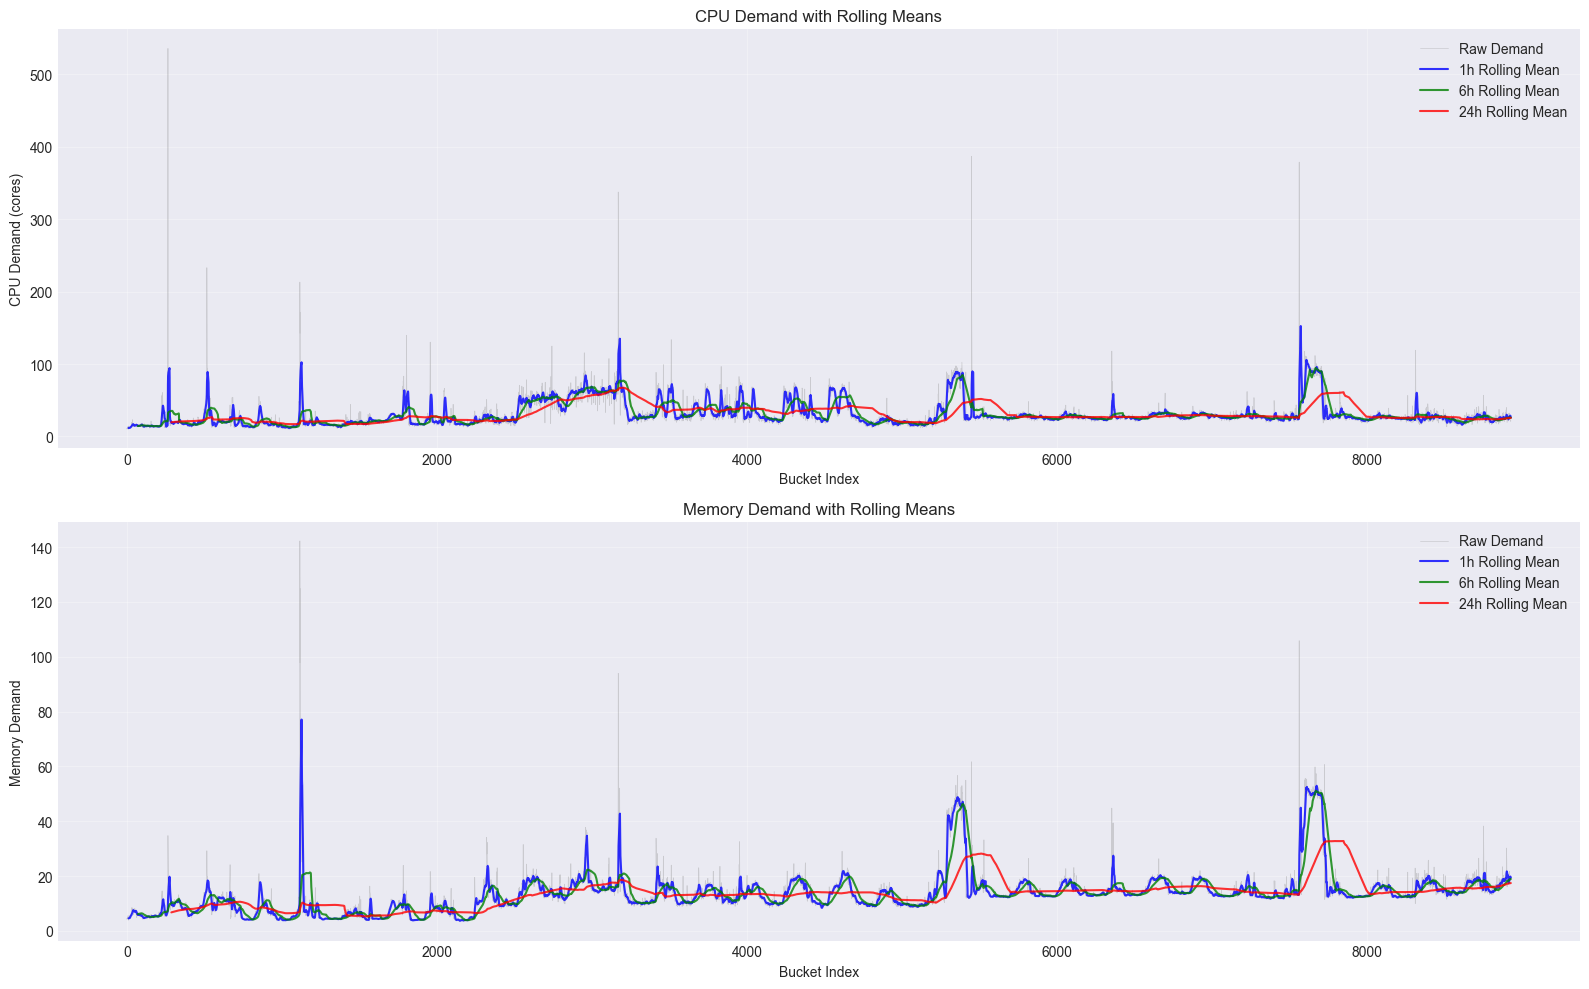

In [14]:
# Plot rolling statistics
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# CPU demand with rolling means
axes[0].plot(cl_pd['bucket_index'], cl_pd['cpu_demand'], linewidth=0.5, alpha=0.3, 
             color='gray', label='Raw Demand')
axes[0].plot(cl_pd['bucket_index'], cl_pd['cpu_rolling_mean_1h'], linewidth=1.5, 
             alpha=0.8, color='blue', label='1h Rolling Mean')
axes[0].plot(cl_pd['bucket_index'], cl_pd['cpu_rolling_mean_6h'], linewidth=1.5, 
             alpha=0.8, color='green', label='6h Rolling Mean')
axes[0].plot(cl_pd['bucket_index'], cl_pd['cpu_rolling_mean_24h'], linewidth=1.5, 
             alpha=0.8, color='red', label='24h Rolling Mean')
axes[0].set_xlabel('Bucket Index')
axes[0].set_ylabel('CPU Demand (cores)')
axes[0].set_title('CPU Demand with Rolling Means')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Memory demand with rolling means
axes[1].plot(cl_pd['bucket_index'], cl_pd['mem_demand'], linewidth=0.5, alpha=0.3, 
             color='gray', label='Raw Demand')
axes[1].plot(cl_pd['bucket_index'], cl_pd['mem_rolling_mean_1h'], linewidth=1.5, 
             alpha=0.8, color='blue', label='1h Rolling Mean')
axes[1].plot(cl_pd['bucket_index'], cl_pd['mem_rolling_mean_6h'], linewidth=1.5, 
             alpha=0.8, color='green', label='6h Rolling Mean')
axes[1].plot(cl_pd['bucket_index'], cl_pd['mem_rolling_mean_24h'], linewidth=1.5, 
             alpha=0.8, color='red', label='24h Rolling Mean')
axes[1].set_xlabel('Bucket Index')
axes[1].set_ylabel('Memory Demand')
axes[1].set_title('Memory Demand with Rolling Means')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Spike Detection

Identify demand spikes using statistical thresholds


In [15]:
# Detect spikes (demand > rolling_mean + 3 * rolling_std)
threshold_sigma = 3

cl_pd['cpu_spike'] = (
    cl_pd['cpu_demand'] > 
    (cl_pd['cpu_rolling_mean_6h'] + threshold_sigma * cl_pd['cpu_rolling_std_6h'])
)

cl_pd['mem_spike'] = (
    cl_pd['mem_demand'] > 
    (cl_pd['mem_rolling_mean_6h'] + threshold_sigma * cl_pd['mem_rolling_std_6h'])
)

cpu_spikes = cl_pd[cl_pd['cpu_spike'] == True]
mem_spikes = cl_pd[cl_pd['mem_spike'] == True]

print("="*80)
print(f"SPIKE DETECTION (threshold: {threshold_sigma}σ above 6h rolling mean)")
print("="*80)
print(f"CPU spikes detected:    {len(cpu_spikes):,} ({len(cpu_spikes)/len(cl_pd)*100:.2f}% of buckets)")
print(f"Memory spikes detected: {len(mem_spikes):,} ({len(mem_spikes)/len(cl_pd)*100:.2f}% of buckets)")

if len(cpu_spikes) > 0:
    print(f"\nCPU spike statistics:")
    print(f"  Max spike magnitude: {cpu_spikes['cpu_demand'].max():.2f} cores")
    print(f"  Mean spike magnitude: {cpu_spikes['cpu_demand'].mean():.2f} cores")

if len(mem_spikes) > 0:
    print(f"\nMemory spike statistics:")
    print(f"  Max spike magnitude: {mem_spikes['mem_demand'].max():.2f} units")
    print(f"  Mean spike magnitude: {mem_spikes['mem_demand'].mean():.2f} units")


SPIKE DETECTION (threshold: 3σ above 6h rolling mean)
CPU spikes detected:    233 (2.61% of buckets)
Memory spikes detected: 311 (3.48% of buckets)

CPU spike statistics:
  Max spike magnitude: 535.82 cores
  Mean spike magnitude: 63.07 cores

Memory spike statistics:
  Max spike magnitude: 142.22 units
  Mean spike magnitude: 19.38 units


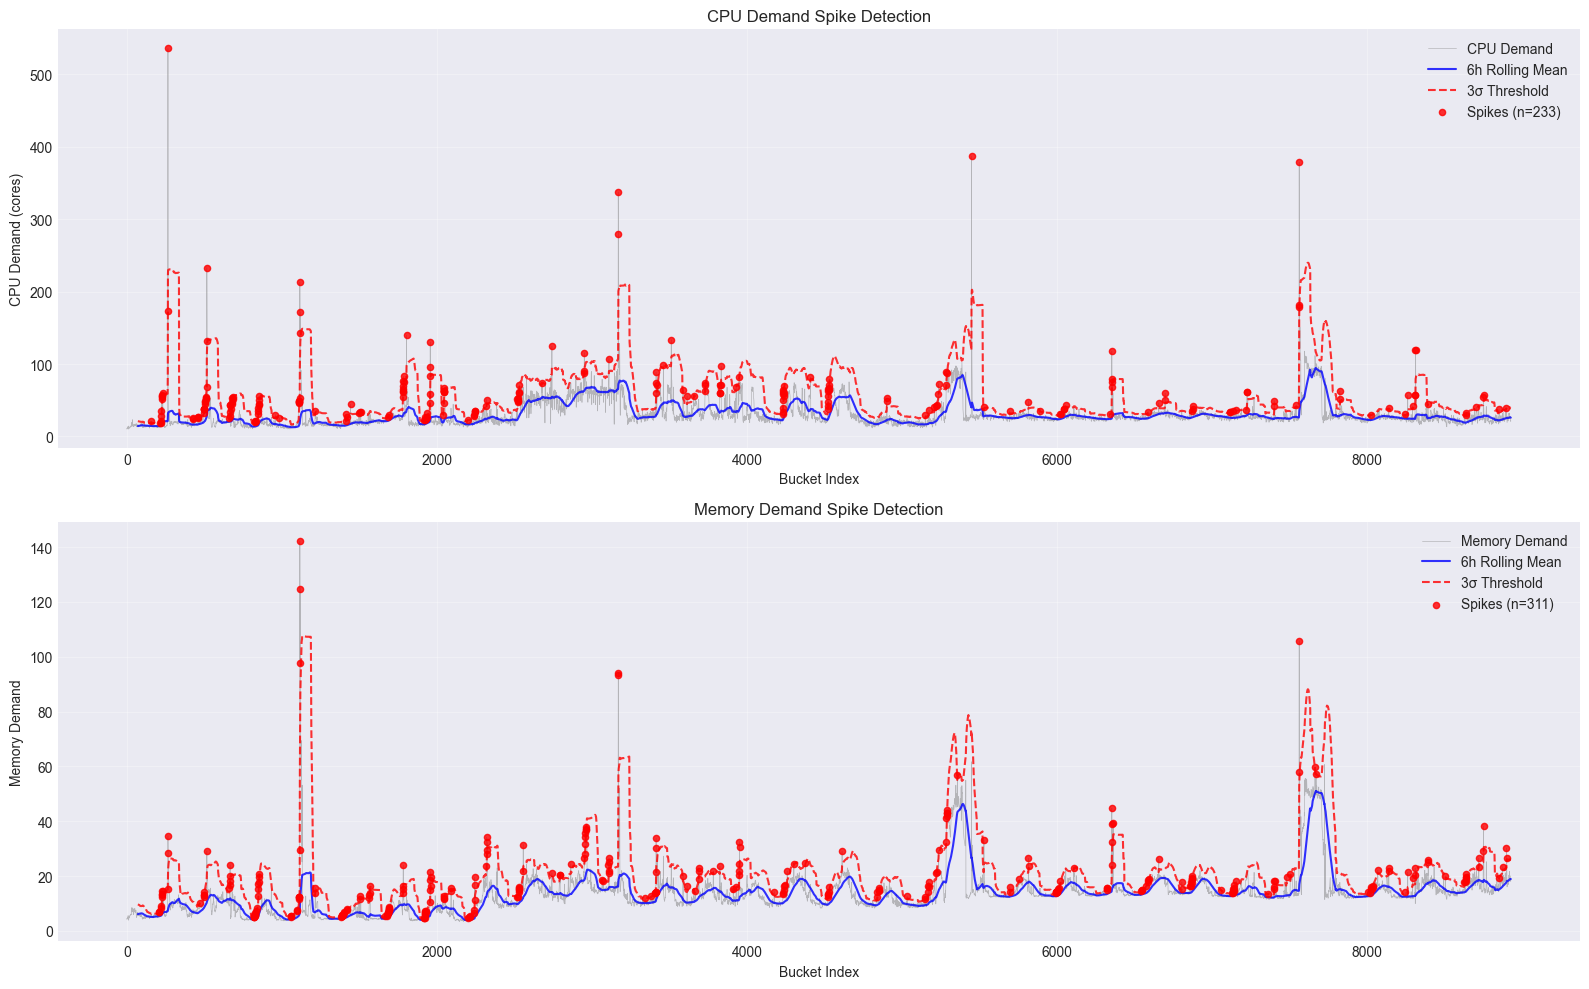


📊 Interpretation:
   - Spikes represent sudden demand increases that challenge reactive autoscaling
   - Proactive/predictive autoscaling can mitigate spike impact
   - RL agents must learn to anticipate and handle these events


In [16]:
# Plot spikes
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# CPU spikes
axes[0].plot(cl_pd['bucket_index'], cl_pd['cpu_demand'], linewidth=0.5, alpha=0.5, 
             color='gray', label='CPU Demand')
axes[0].plot(cl_pd['bucket_index'], cl_pd['cpu_rolling_mean_6h'], linewidth=1.5, 
             alpha=0.8, color='blue', label='6h Rolling Mean')
axes[0].plot(cl_pd['bucket_index'], 
             cl_pd['cpu_rolling_mean_6h'] + threshold_sigma * cl_pd['cpu_rolling_std_6h'],
             linewidth=1.5, alpha=0.8, color='red', linestyle='--', label=f'{threshold_sigma}σ Threshold')
axes[0].scatter(cpu_spikes['bucket_index'], cpu_spikes['cpu_demand'], 
                color='red', s=20, alpha=0.8, label=f'Spikes (n={len(cpu_spikes)})', zorder=5)
axes[0].set_xlabel('Bucket Index')
axes[0].set_ylabel('CPU Demand (cores)')
axes[0].set_title('CPU Demand Spike Detection')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Memory spikes
axes[1].plot(cl_pd['bucket_index'], cl_pd['mem_demand'], linewidth=0.5, alpha=0.5, 
             color='gray', label='Memory Demand')
axes[1].plot(cl_pd['bucket_index'], cl_pd['mem_rolling_mean_6h'], linewidth=1.5, 
             alpha=0.8, color='blue', label='6h Rolling Mean')
axes[1].plot(cl_pd['bucket_index'], 
             cl_pd['mem_rolling_mean_6h'] + threshold_sigma * cl_pd['mem_rolling_std_6h'],
             linewidth=1.5, alpha=0.8, color='red', linestyle='--', label=f'{threshold_sigma}σ Threshold')
axes[1].scatter(mem_spikes['bucket_index'], mem_spikes['mem_demand'], 
                color='red', s=20, alpha=0.8, label=f'Spikes (n={len(mem_spikes)})', zorder=5)
axes[1].set_xlabel('Bucket Index')
axes[1].set_ylabel('Memory Demand')
axes[1].set_title('Memory Demand Spike Detection')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   - Spikes represent sudden demand increases that challenge reactive autoscaling")
print("   - Proactive/predictive autoscaling can mitigate spike impact")
print("   - RL agents must learn to anticipate and handle these events")


## 8. ACF/PACF Analysis for Forecastability

Assess temporal autocorrelation to determine predictability


In [17]:
# Compute ACF and PACF for CPU demand
max_lags = 288  # 24 hours worth of lags

cpu_acf = acf(cl_pd['cpu_demand'].dropna(), nlags=max_lags, fft=True)
cpu_pacf_vals = pacf(cl_pd['cpu_demand'].dropna(), nlags=max_lags)

mem_acf = acf(cl_pd['mem_demand'].dropna(), nlags=max_lags, fft=True)
mem_pacf_vals = pacf(cl_pd['mem_demand'].dropna(), nlags=max_lags)

print("✅ Computed ACF/PACF for CPU and Memory demand")


✅ Computed ACF/PACF for CPU and Memory demand


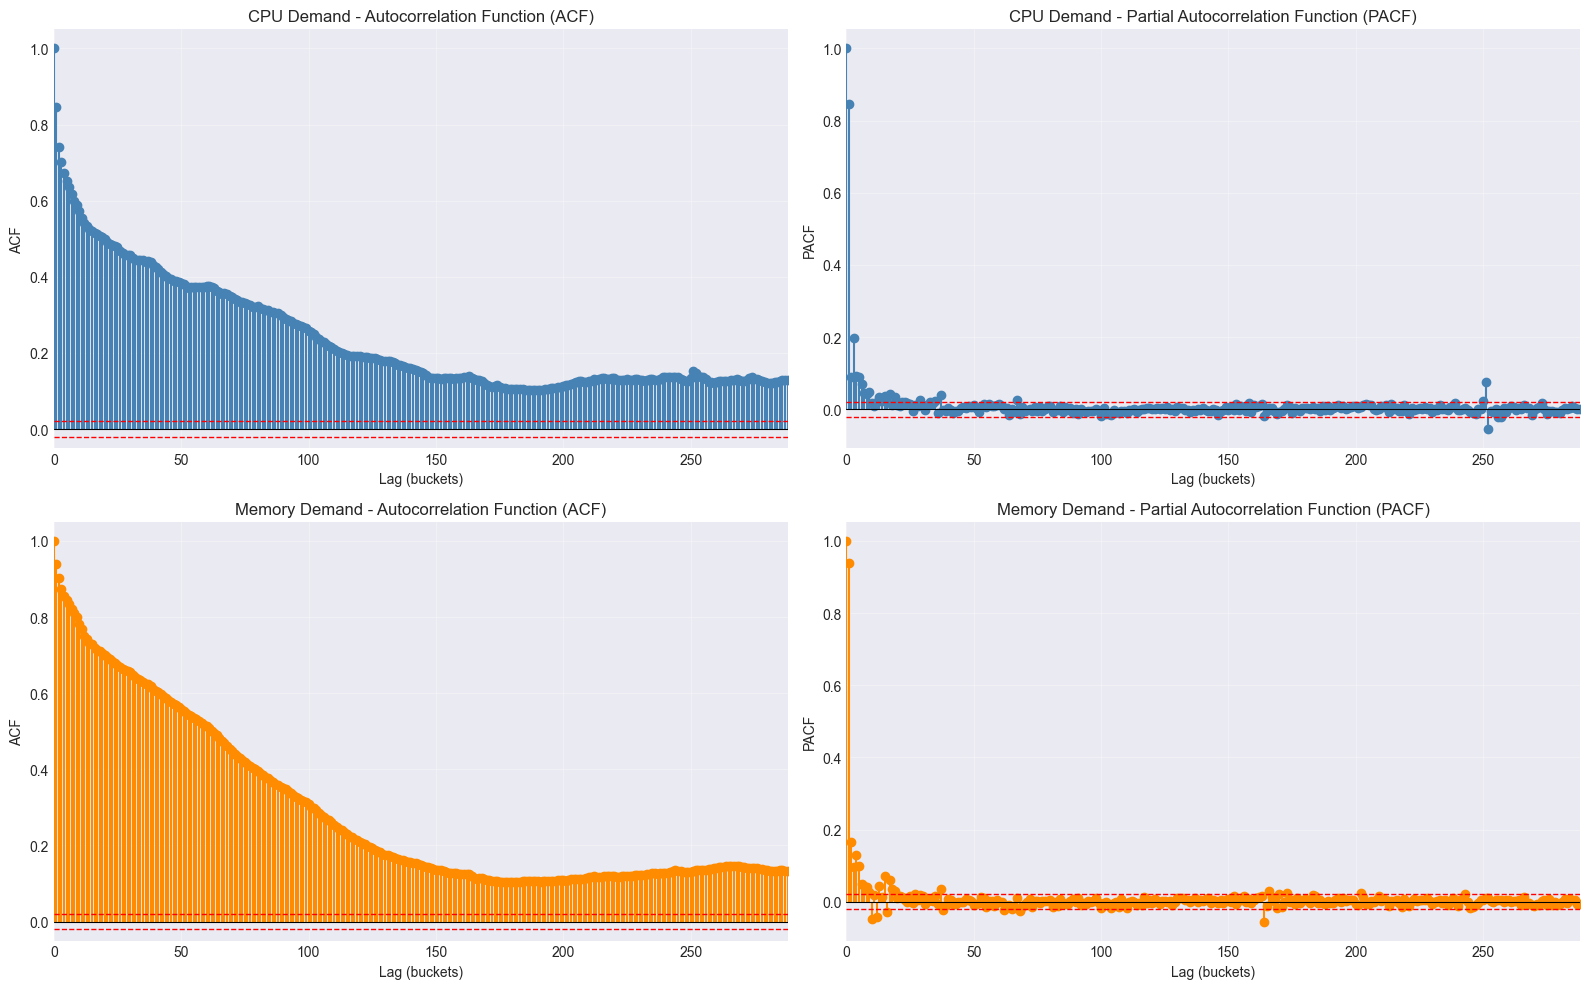

In [18]:
# Plot ACF and PACF
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# CPU ACF
axes[0, 0].stem(range(len(cpu_acf)), cpu_acf, linefmt='steelblue', markerfmt='o', basefmt=' ')
axes[0, 0].axhline(y=0, color='black', linewidth=0.8)
axes[0, 0].axhline(y=1.96/np.sqrt(len(cl_pd)), color='red', linestyle='--', linewidth=1)
axes[0, 0].axhline(y=-1.96/np.sqrt(len(cl_pd)), color='red', linestyle='--', linewidth=1)
axes[0, 0].set_xlabel('Lag (buckets)')
axes[0, 0].set_ylabel('ACF')
axes[0, 0].set_title('CPU Demand - Autocorrelation Function (ACF)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim(0, max_lags)

# CPU PACF
axes[0, 1].stem(range(len(cpu_pacf_vals)), cpu_pacf_vals, linefmt='steelblue', markerfmt='o', basefmt=' ')
axes[0, 1].axhline(y=0, color='black', linewidth=0.8)
axes[0, 1].axhline(y=1.96/np.sqrt(len(cl_pd)), color='red', linestyle='--', linewidth=1)
axes[0, 1].axhline(y=-1.96/np.sqrt(len(cl_pd)), color='red', linestyle='--', linewidth=1)
axes[0, 1].set_xlabel('Lag (buckets)')
axes[0, 1].set_ylabel('PACF')
axes[0, 1].set_title('CPU Demand - Partial Autocorrelation Function (PACF)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim(0, max_lags)

# Memory ACF
axes[1, 0].stem(range(len(mem_acf)), mem_acf, linefmt='darkorange', markerfmt='o', basefmt=' ')
axes[1, 0].axhline(y=0, color='black', linewidth=0.8)
axes[1, 0].axhline(y=1.96/np.sqrt(len(cl_pd)), color='red', linestyle='--', linewidth=1)
axes[1, 0].axhline(y=-1.96/np.sqrt(len(cl_pd)), color='red', linestyle='--', linewidth=1)
axes[1, 0].set_xlabel('Lag (buckets)')
axes[1, 0].set_ylabel('ACF')
axes[1, 0].set_title('Memory Demand - Autocorrelation Function (ACF)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim(0, max_lags)

# Memory PACF
axes[1, 1].stem(range(len(mem_pacf_vals)), mem_pacf_vals, linefmt='darkorange', markerfmt='o', basefmt=' ')
axes[1, 1].axhline(y=0, color='black', linewidth=0.8)
axes[1, 1].axhline(y=1.96/np.sqrt(len(cl_pd)), color='red', linestyle='--', linewidth=1)
axes[1, 1].axhline(y=-1.96/np.sqrt(len(cl_pd)), color='red', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Lag (buckets)')
axes[1, 1].set_ylabel('PACF')
axes[1, 1].set_title('Memory Demand - Partial Autocorrelation Function (PACF)')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim(0, max_lags)

plt.tight_layout()
plt.show()


In [19]:
# Analyze forecastability
# Count significant lags (outside confidence interval)
confidence_bound = 1.96 / np.sqrt(len(cl_pd))
significant_cpu_acf = np.sum(np.abs(cpu_acf[1:]) > confidence_bound)
significant_mem_acf = np.sum(np.abs(mem_acf[1:]) > confidence_bound)

print("="*80)
print("FORECASTABILITY ANALYSIS")
print("="*80)
print(f"Significant ACF lags (CPU):    {significant_cpu_acf}/{max_lags} "
      f"({significant_cpu_acf/max_lags*100:.1f}%)")
print(f"Significant ACF lags (Memory): {significant_mem_acf}/{max_lags} "
      f"({significant_mem_acf/max_lags*100:.1f}%)")

# Analyze decay rate
cpu_acf_decay = np.where(cpu_acf[1:] < confidence_bound)[0]
mem_acf_decay = np.where(mem_acf[1:] < confidence_bound)[0]

if len(cpu_acf_decay) > 0:
    cpu_decay_lag = cpu_acf_decay[0] + 1
    print(f"\nCPU ACF decays to insignificance at lag {cpu_decay_lag} "
          f"({cpu_decay_lag * 5} minutes)")
else:
    print(f"\nCPU ACF remains significant throughout {max_lags} lags (strong persistence)")

if len(mem_acf_decay) > 0:
    mem_decay_lag = mem_acf_decay[0] + 1
    print(f"Memory ACF decays to insignificance at lag {mem_decay_lag} "
          f"({mem_decay_lag * 5} minutes)")
else:
    print(f"Memory ACF remains significant throughout {max_lags} lags (strong persistence)")

print("\n📊 Interpretation:")
print("   - Strong ACF at multiple lags → demand is predictable")
print("   - Slow ACF decay → long-term dependencies exist")
print("   - This supports ML-based forecasting and proactive autoscaling")
print("   - RL agents can exploit temporal patterns for better decisions")


FORECASTABILITY ANALYSIS
Significant ACF lags (CPU):    288/288 (100.0%)
Significant ACF lags (Memory): 288/288 (100.0%)

CPU ACF remains significant throughout 288 lags (strong persistence)
Memory ACF remains significant throughout 288 lags (strong persistence)

📊 Interpretation:
   - Strong ACF at multiple lags → demand is predictable
   - Slow ACF decay → long-term dependencies exist
   - This supports ML-based forecasting and proactive autoscaling
   - RL agents can exploit temporal patterns for better decisions


## 9. Correlation Analysis


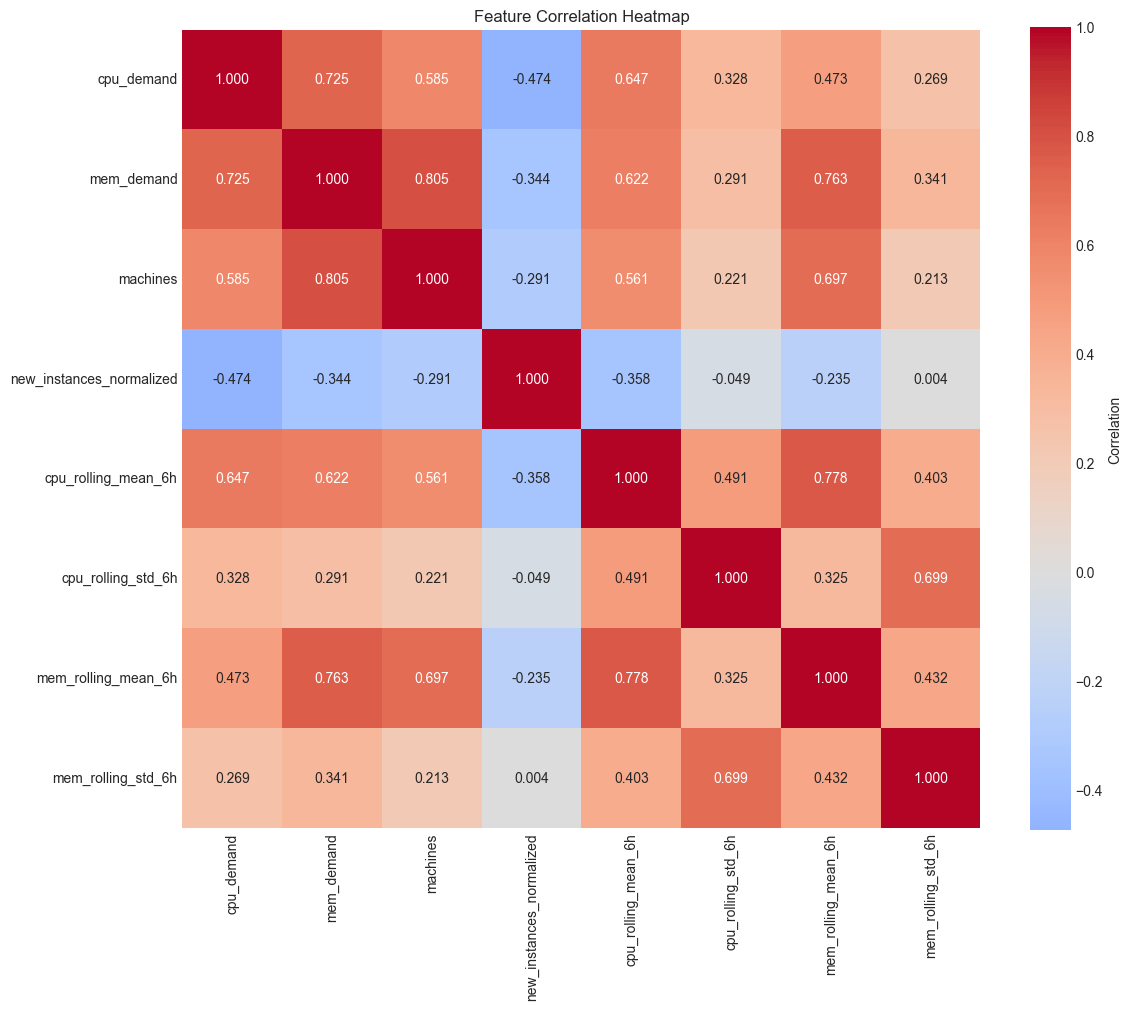

KEY CORRELATIONS
CPU-Memory Correlation:          0.7252
CPU-Machines Correlation:        0.5854
Memory-Machines Correlation:     0.8046
CPU-NewInstances Correlation:    -0.4739

📊 Interpretation:
   - High CPU-Memory correlation → resources scale together
   - CPU-Machines correlation shows how well cluster tracked demand
   - Low NewInstances correlation confirms events/usage mismatch


In [20]:
# Correlation heatmap
corr_features = [
    'cpu_demand', 'mem_demand', 'machines', 'new_instances_normalized',
    'cpu_rolling_mean_6h', 'cpu_rolling_std_6h',
    'mem_rolling_mean_6h', 'mem_rolling_std_6h'
]

corr_matrix = cl_pd[corr_features].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print("="*80)
print("KEY CORRELATIONS")
print("="*80)
print(f"CPU-Memory Correlation:          {cl_pd['cpu_demand'].corr(cl_pd['mem_demand']):.4f}")
print(f"CPU-Machines Correlation:        {cl_pd['cpu_demand'].corr(cl_pd['machines']):.4f}")
print(f"Memory-Machines Correlation:     {cl_pd['mem_demand'].corr(cl_pd['machines']):.4f}")
print(f"CPU-NewInstances Correlation:    {cl_pd['cpu_demand'].corr(cl_pd['new_instances_normalized']):.4f}")

print("\n📊 Interpretation:")
print("   - High CPU-Memory correlation → resources scale together")
print("   - CPU-Machines correlation shows how well cluster tracked demand")
print("   - Low NewInstances correlation confirms events/usage mismatch")


## 10. ML-Ready Feature Engineering

Create a final dataset with engineered features for ML modeling


In [21]:
# Create lag features
lag_steps = [1, 5, 10, 20, 50, 100]

for lag in lag_steps:
    cl_pd[f'cpu_demand_lag{lag}'] = cl_pd['cpu_demand'].shift(lag)
    cl_pd[f'mem_demand_lag{lag}'] = cl_pd['mem_demand'].shift(lag)

print(f"✅ Created lag features: {lag_steps}")


✅ Created lag features: [1, 5, 10, 20, 50, 100]


In [22]:
# Create cyclical features for synthetic time patterns
# These are SYNTHETIC and used ONLY for pattern detection
buckets_per_hour = 12
buckets_per_day = 288

cl_pd['sin_hour'] = np.sin(2 * np.pi * cl_pd['bucket_index'] / buckets_per_hour)
cl_pd['cos_hour'] = np.cos(2 * np.pi * cl_pd['bucket_index'] / buckets_per_hour)
cl_pd['sin_day'] = np.sin(2 * np.pi * cl_pd['bucket_index'] / buckets_per_day)
cl_pd['cos_day'] = np.cos(2 * np.pi * cl_pd['bucket_index'] / buckets_per_day)

print("✅ Created cyclical features (synthetic time patterns)")
print("   NOTE: These are NOT based on real timestamps, use for seasonality detection only")


✅ Created cyclical features (synthetic time patterns)
   NOTE: These are NOT based on real timestamps, use for seasonality detection only


In [23]:
# Create normalized features
cl_pd['machines_normalized'] = (cl_pd['machines'] - cl_pd['machines'].mean()) / cl_pd['machines'].std()
cl_pd['cpu_demand_normalized'] = (cl_pd['cpu_demand'] - cl_pd['cpu_demand'].mean()) / cl_pd['cpu_demand'].std()
cl_pd['mem_demand_normalized'] = (cl_pd['mem_demand'] - cl_pd['mem_demand'].mean()) / cl_pd['mem_demand'].std()

print("✅ Created normalized features (z-score)")


✅ Created normalized features (z-score)


In [24]:
# Compile ML-ready dataset
ml_features = [
    'bucket_index',
    'cpu_demand', 'mem_demand',
    'machines', 'new_instances_normalized',
    'cpu_rolling_mean_1h', 'cpu_rolling_std_1h',
    'cpu_rolling_mean_6h', 'cpu_rolling_std_6h',
    'cpu_rolling_mean_24h', 'cpu_rolling_std_24h',
    'mem_rolling_mean_1h', 'mem_rolling_std_1h',
    'mem_rolling_mean_6h', 'mem_rolling_std_6h',
    'mem_rolling_mean_24h', 'mem_rolling_std_24h',
] + [f'cpu_demand_lag{lag}' for lag in lag_steps] + \
  [f'mem_demand_lag{lag}' for lag in lag_steps] + \
  ['sin_hour', 'cos_hour', 'sin_day', 'cos_day',
   'machines_normalized', 'cpu_demand_normalized', 'mem_demand_normalized']

ml_ready = cl_pd[ml_features].copy()

# Remove rows with NaN (due to rolling windows and lags)
ml_ready_clean = ml_ready.dropna()

print("="*80)
print("ML-READY DATASET")
print("="*80)
print(f"Total features:     {len(ml_features)}")
print(f"Total rows:         {len(ml_ready):,}")
print(f"Rows after dropna:  {len(ml_ready_clean):,}")
print(f"Rows dropped:       {len(ml_ready) - len(ml_ready_clean):,}")

print("\nFeature list:")
for i, feat in enumerate(ml_features, 1):
    print(f"  {i:2d}. {feat}")


ML-READY DATASET
Total features:     36
Total rows:         8,929
Rows after dropna:  8,642
Rows dropped:       287

Feature list:
   1. bucket_index
   2. cpu_demand
   3. mem_demand
   4. machines
   5. new_instances_normalized
   6. cpu_rolling_mean_1h
   7. cpu_rolling_std_1h
   8. cpu_rolling_mean_6h
   9. cpu_rolling_std_6h
  10. cpu_rolling_mean_24h
  11. cpu_rolling_std_24h
  12. mem_rolling_mean_1h
  13. mem_rolling_std_1h
  14. mem_rolling_mean_6h
  15. mem_rolling_std_6h
  16. mem_rolling_mean_24h
  17. mem_rolling_std_24h
  18. cpu_demand_lag1
  19. cpu_demand_lag5
  20. cpu_demand_lag10
  21. cpu_demand_lag20
  22. cpu_demand_lag50
  23. cpu_demand_lag100
  24. mem_demand_lag1
  25. mem_demand_lag5
  26. mem_demand_lag10
  27. mem_demand_lag20
  28. mem_demand_lag50
  29. mem_demand_lag100
  30. sin_hour
  31. cos_hour
  32. sin_day
  33. cos_day
  34. machines_normalized
  35. cpu_demand_normalized
  36. mem_demand_normalized


In [25]:
# Display sample of ML-ready data
print("\nML-Ready Dataset Sample:")
display(ml_ready_clean.head(10))

print("\nML-Ready Dataset Statistics:")
display(ml_ready_clean.describe())



ML-Ready Dataset Sample:


,bucket_index,cpu_demand,mem_demand,machines,new_instances_normalized,cpu_rolling_mean_1h,cpu_rolling_std_1h,cpu_rolling_mean_6h,cpu_rolling_std_6h,cpu_rolling_mean_24h,...,mem_demand_lag20,mem_demand_lag50,mem_demand_lag100,sin_hour,cos_hour,sin_day,cos_day,machines_normalized,cpu_demand_normalized,mem_demand_normalized
287,287,19.860699,10.424101,2349,1184.600762,18.896533,2.504884,35.332024,65.174439,19.616617,...,20.885680,6.484003,5.400404,-5.000000e-01,8.660254e-01,-2.181489e-02,0.999762,-1.317655,-0.558848,-0.392389
288,288,18.825440,9.617826,2362,1500.150748,18.488017,1.992753,35.331647,65.174536,19.646277,...,19.372990,7.613410,5.530549,-5.878305e-15,1.000000e+00,-2.449294e-16,1.000000,-1.300204,-0.610983,-0.492239
289,289,17.154090,8.983951,2396,2510.829643,18.465875,2.007125,35.333030,65.174143,19.667239,...,18.695606,7.483712,5.209405,5.000000e-01,8.660254e-01,2.181489e-02,0.999762,-1.254562,-0.695150,-0.570740
290,290,20.879363,9.857216,2406,1215.650052,18.672055,2.124001,35.359862,65.167700,19.703788,...,18.391441,7.463216,5.407324,8.660254e-01,5.000000e-01,4.361939e-02,0.999048,-1.241139,-0.507550,-0.462593
291,291,19.212366,9.972530,2415,1115.739663,19.014098,1.804279,35.328252,65.175075,19.727720,...,17.598574,7.062719,5.134537,1.000000e+00,1.126861e-14,6.540313e-02,0.997859,-1.229057,-0.591498,-0.448312
292,292,17.690833,9.641525,2409,1213.848928,19.260104,1.298810,35.358858,65.166143,19.746592,...,16.790469,7.040133,5.038338,8.660254e-01,-5.000000e-01,8.715574e-02,0.996195,-1.237111,-0.668120,-0.489304
293,293,16.453825,8.625987,2342,1442.156979,19.025394,1.530597,35.356136,65.166940,19.763074,...,16.026044,6.851391,5.405061,5.000000e-01,-8.660254e-01,1.088669e-01,0.994056,-1.327051,-0.730414,-0.615071
294,294,16.436177,8.451407,2343,1375.623922,18.806942,1.702948,35.186038,65.200577,19.776081,...,16.230310,5.331971,5.588960,-1.176280e-14,-1.000000e+00,1.305262e-01,0.991445,-1.325709,-0.731303,-0.636691
295,295,16.077573,8.317096,2343,1409.478834,18.644141,1.869126,34.925162,65.239463,19.790119,...,14.535624,5.458485,5.715286,-5.000000e-01,-8.660254e-01,1.521234e-01,0.988362,-1.325709,-0.749362,-0.653324
296,296,16.979321,8.672298,2316,1355.472300,18.298549,1.747899,34.437216,65.240493,19.800179,...,12.711758,5.975489,5.549134,-8.660254e-01,-5.000000e-01,1.736482e-01,0.984808,-1.361953,-0.703951,-0.609335



ML-Ready Dataset Statistics:


,bucket_index,cpu_demand,mem_demand,machines,new_instances_normalized,cpu_rolling_mean_1h,cpu_rolling_std_1h,cpu_rolling_mean_6h,cpu_rolling_std_6h,cpu_rolling_mean_24h,...,mem_demand_lag20,mem_demand_lag50,mem_demand_lag100,sin_hour,cos_hour,sin_day,cos_day,machines_normalized,cpu_demand_normalized,mem_demand_normalized
count,8642.000000,8642.000000,8642.000000,8642.000000,8642.000000,8642.000000,8642.000000,8642.000000,8642.000000,8642.000000,...,8642.000000,8642.000000,8642.000000,8.642000e+03,8.642000e+03,8.642000e+03,8.642000e+03,8642.000000,8642.000000,8642.000000
mean,4607.500000,31.334737,13.820182,3368.097200,1279.431758,31.331277,4.986331,31.381220,8.917539,31.307036,...,13.806970,13.768762,13.711700,-5.785698e-05,2.159252e-04,-2.524287e-06,2.314004e-04,0.050369,0.018969,0.028189
std,2494.874847,19.112527,8.084978,723.518166,722.427943,16.754007,8.214951,14.328476,10.332086,11.154810,...,8.083518,8.089244,8.101692,7.070863e-01,7.072090e-01,7.070659e-01,7.072294e-01,0.971242,0.962481,1.001260
min,287.000000,10.299766,3.409730,1587.000000,59.305027,11.456213,0.363024,12.597447,0.940421,16.962755,...,3.409730,3.409730,3.409730,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-2.340554,-1.040324,-1.261062
25%,2447.250000,21.115318,9.949055,3040.500000,767.234742,21.858824,1.708343,23.198557,2.881826,23.742351,...,9.939871,9.903414,9.858895,-5.000000e-01,-5.000000e-01,-7.071068e-01,-7.071068e-01,-0.389393,-0.495667,-0.451219
50%,4607.500000,25.841424,12.893011,3421.000000,1146.555440,26.232086,2.811326,26.915547,4.703355,27.090415,...,12.885034,12.866254,12.835276,-1.000763e-15,-4.966675e-16,-6.129424e-16,-4.583141e-16,0.121385,-0.257667,-0.086634
75%,6767.750000,31.938678,15.691711,3744.000000,1639.489932,31.651204,5.169304,35.179182,11.658148,37.479909,...,15.670424,15.624774,15.548092,5.000000e-01,8.660254e-01,7.071068e-01,7.071068e-01,0.554977,0.049383,0.259963
max,8928.000000,386.982372,142.220225,7499.000000,7864.251561,152.475253,111.946404,94.497637,65.240493,67.348339,...,142.220225,142.220225,142.220225,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.595644,17.928911,15.929502


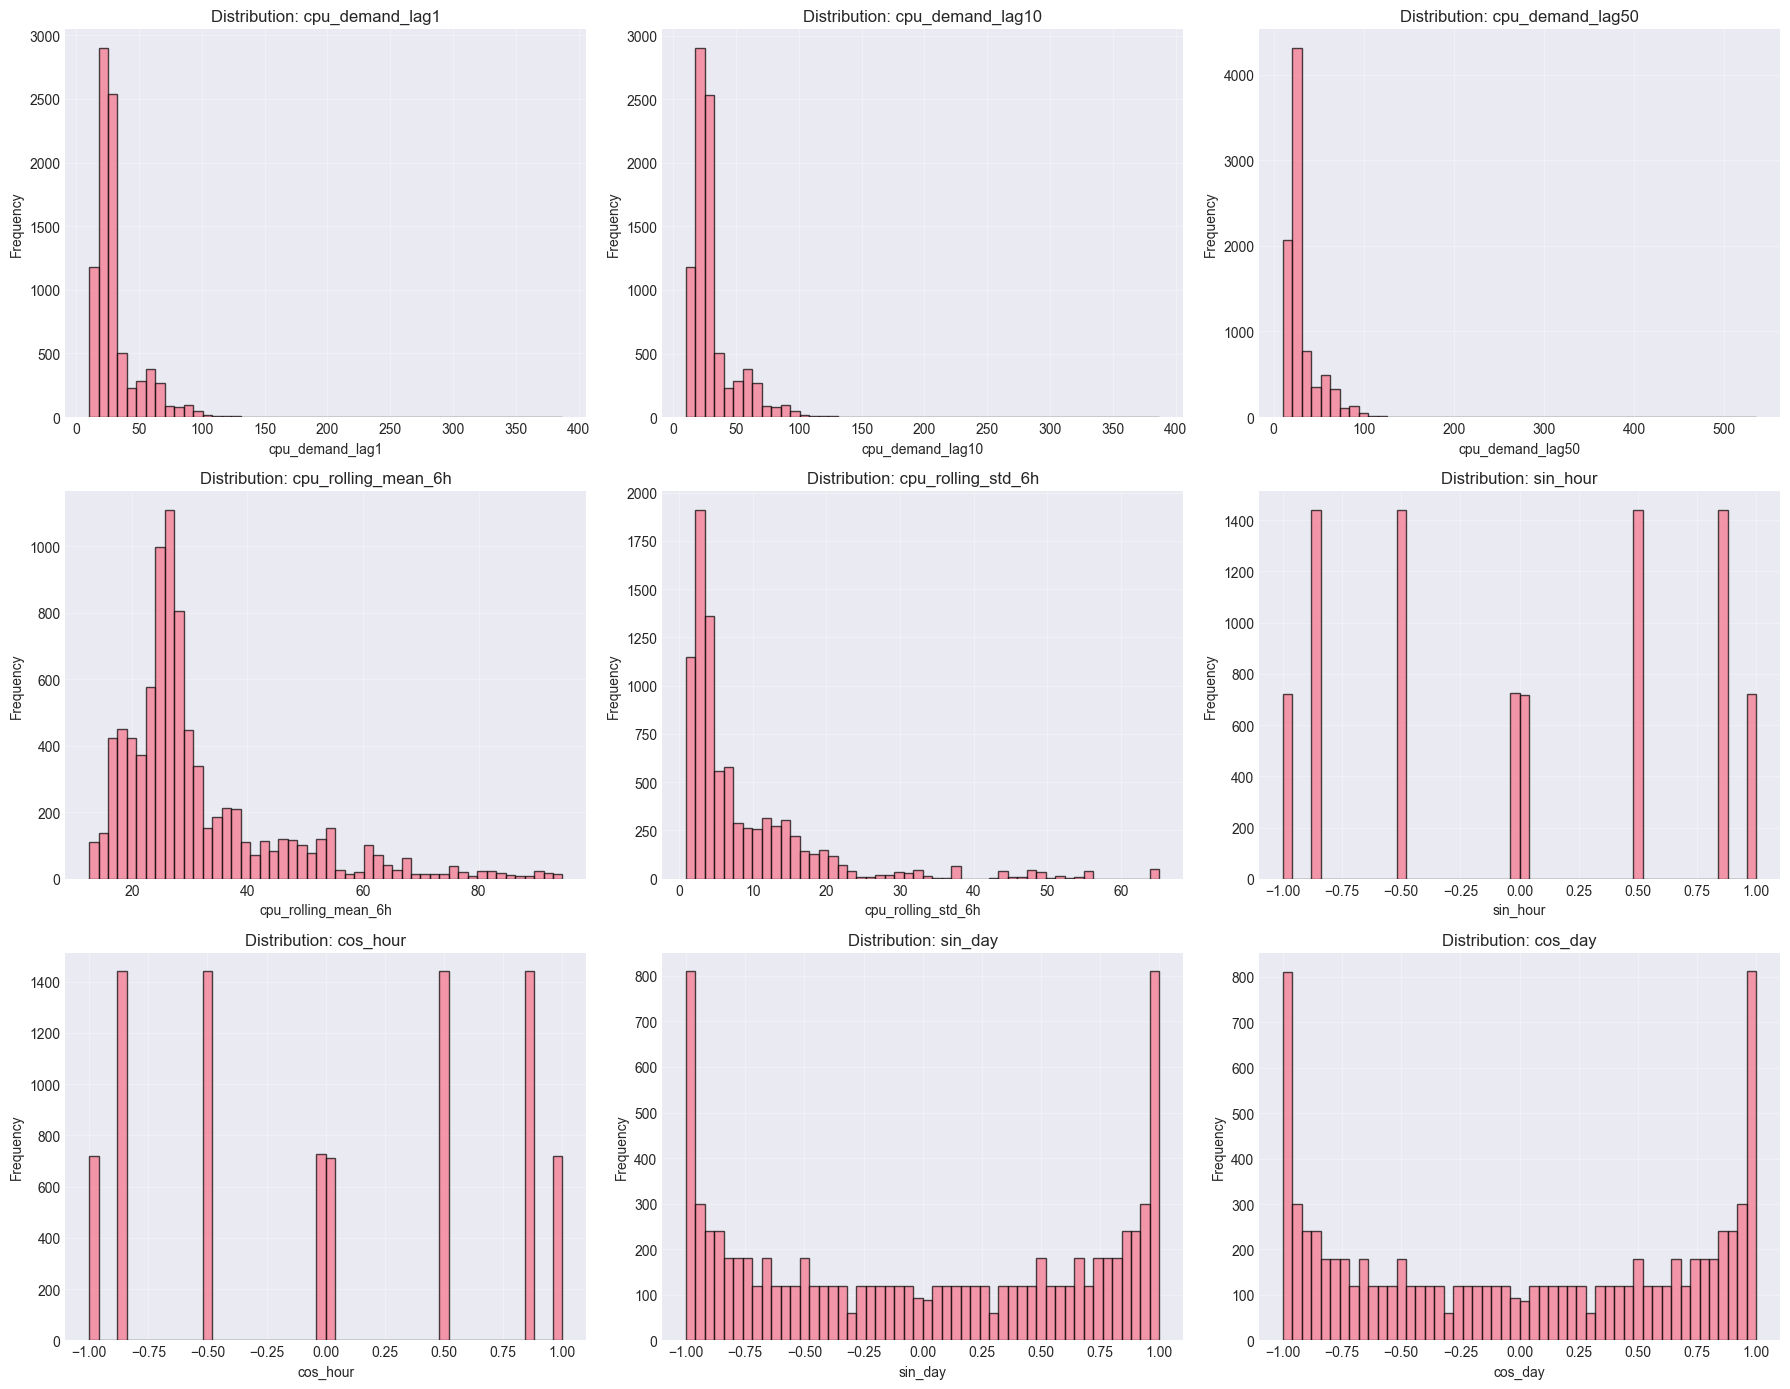

In [26]:
# Plot distributions of key engineered features
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

plot_features = [
    'cpu_demand_lag1', 'cpu_demand_lag10', 'cpu_demand_lag50',
    'cpu_rolling_mean_6h', 'cpu_rolling_std_6h',
    'sin_hour', 'cos_hour', 'sin_day', 'cos_day'
]

for i, feat in enumerate(plot_features):
    axes[i].hist(ml_ready_clean[feat].dropna(), bins=50, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(feat)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution: {feat}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [27]:
# Save ML-ready dataset
output_path = output_dir / "ml_ready_features.csv"
ml_ready_clean.to_csv(output_path, index=False)
print(f"✅ Saved ML-ready dataset to: {output_path}")
print(f"   Shape: {ml_ready_clean.shape}")


✅ Saved ML-ready dataset to: eda_summary/ml_ready_features.csv
   Shape: (8642, 36)


## 11. Autoscaler-Ready Summary

Final summary of demand characteristics and autoscaling implications


In [28]:
# Compile summary statistics
summary = {
    'Temporal Coverage': {
        'Total Buckets': len(cl),
        'Duration (hours)': total_duration_hours,
        'Duration (days)': total_duration_days,
        'Bucket Interval': '5 minutes',
        'Missing Buckets': len(missing_buckets)
    },
    'Demand Statistics': {
        'CPU Mean': f"{cl_pd['cpu_demand'].mean():.2f} cores",
        'CPU Std': f"{cl_pd['cpu_demand'].std():.2f} cores",
        'CPU Max': f"{cl_pd['cpu_demand'].max():.2f} cores",
        'CPU P99': f"{np.percentile(cl_pd['cpu_demand'], 99):.2f} cores",
        'Memory Mean': f"{cl_pd['mem_demand'].mean():.2f} units",
        'Memory Std': f"{cl_pd['mem_demand'].std():.2f} units",
        'Memory Max': f"{cl_pd['mem_demand'].max():.2f} units",
        'Memory P99': f"{np.percentile(cl_pd['mem_demand'], 99):.2f} units"
    },
    'Burstiness': {
        'CPU CV': f"{cpu_cv:.4f}",
        'Memory CV': f"{mem_cv:.4f}",
        'CPU Spikes': f"{len(cpu_spikes)} ({len(cpu_spikes)/len(cl_pd)*100:.2f}%)",
        'Memory Spikes': f"{len(mem_spikes)} ({len(mem_spikes)/len(cl_pd)*100:.2f}%)"
    },
    'Predictability': {
        'CPU Significant ACF Lags': f"{significant_cpu_acf}/{max_lags}",
        'Memory Significant ACF Lags': f"{significant_mem_acf}/{max_lags}",
        'Strong Temporal Patterns': 'Yes' if significant_cpu_acf > max_lags * 0.5 else 'Moderate'
    },
    'Instance Events': {
        'Total New Instances': f"{cl_pd['new_instances_cluster'].sum():,}",
        'Mean per Bucket': f"{cl_pd['new_instances_cluster'].mean():.2f}",
        'Events/Usage Alignment': 'Poor - requires normalization'
    },
    'Machine Coverage': {
        'Total Unique Machines': f"{total_unique_machines:,}",
        'Mean Machines per Bucket': f"{cl_pd['machines'].mean():.0f}",
        'Machine Count Range': f"{cl_pd['machines'].min():,} - {cl_pd['machines'].max():,}"
    }
}

print("="*80)
print("AUTOSCALER-READY SUMMARY")
print("="*80)
for category, metrics in summary.items():
    print(f"\n{category}:")
    for key, value in metrics.items():
        print(f"  {key:30s}: {value}")


AUTOSCALER-READY SUMMARY

Temporal Coverage:
  Total Buckets                 : 8929
  Duration (hours)              : 744.0833333333334
  Duration (days)               : 31.003472222222225
  Bucket Interval               : 5 minutes
  Missing Buckets               : 0

Demand Statistics:
  CPU Mean                      : 30.96 cores
  CPU Std                       : 19.86 cores
  CPU Max                       : 535.82 cores
  CPU P99                       : 94.44 cores
  Memory Mean                   : 13.59 units
  Memory Std                    : 8.07 units
  Memory Max                    : 142.22 units
  Memory P99                    : 50.08 units

Burstiness:
  CPU CV                        : 0.6414
  Memory CV                     : 0.5941
  CPU Spikes                    : 233 (2.61%)
  Memory Spikes                 : 311 (3.48%)

Predictability:
  CPU Significant ACF Lags      : 288/288
  Memory Significant ACF Lags   : 288/288
  Strong Temporal Patterns      : Yes

Instance Events

## Key Findings & Autoscaling Implications

### 1. True Demand Characteristics
- **CPU demand** shows moderate to high variability (CV indicates burstiness)
- **Memory demand** follows similar but not identical patterns
- **P99 demand** significantly exceeds mean, requiring headroom in capacity planning

### 2. Burst Patterns
- Demand spikes detected using statistical thresholds (3σ above rolling mean)
- Spikes represent sudden increases that challenge reactive autoscaling
- Proactive/predictive autoscaling can mitigate spike impact

### 3. Degree of Predictability
- **Strong autocorrelation** at multiple lags indicates temporal dependencies
- Slow ACF decay suggests long-term patterns exist
- This supports ML-based forecasting and proactive autoscaling strategies

### 4. Misalignment Between Usage and Instance Events
- `new_instances_cluster` includes tasks that may NOT appear in usage data
- Instance arrivals far exceed demand in many buckets
- **Critical:** Instance events must be normalized before use in ML or autoscaling

### 5. Expected Autoscaler Challenges
- **Reactive policies** will struggle with sudden spikes
- **Over-provisioning** needed to handle P99 scenarios
- **Under-utilization** likely during low-demand periods
- **Startup delays** for new machines compound latency

### 6. Reinforcement Learning Motivations
- RL can learn to **anticipate** demand patterns from temporal features
- RL can **balance** multiple objectives (cost, SLA, utilization)
- RL can **adapt** to non-stationary demand over time
- RL can exploit **long-term dependencies** revealed by ACF analysis

### 7. Why Capacity Must Be Simulated
- `machines` column represents machines **reporting usage**, NOT total capacity
- No ground truth for actual cluster capacity exists in the trace
- Simulator must model capacity decisions and constraints
- This allows testing different autoscaling policies against the same demand

---

## Next Steps

1. **Baseline Autoscaling Simulation**
   - Implement threshold-based, target-tracking, and predictive policies
   - Measure SLA violations, cost, and utilization

2. **ML-Based Demand Forecasting**
   - Train LSTM/Transformer models on engineered features
   - Evaluate forecast accuracy at different horizons
   - Use forecasts for proactive scaling

3. **RL Agent Training**
   - Design state space (demand, capacity, rolling stats, lags)
   - Design action space (scale up/down by N machines)
   - Design reward function (cost penalty + SLA violation penalty + utilization bonus)
   - Train PPO/SAC agents

4. **Comparative Evaluation**
   - Benchmark all approaches on held-out test period
   - Analyze trade-offs and failure modes
   - Identify scenarios where each approach excels

---

**END OF EDA**
